In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
df_raw = pd.read_csv('data/wa_ev_registrations_public.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (2,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2010-01-06,1.0
2010-02-03,1.0
2010-02-11,1.0
2010-02-16,3.0
2010-03-03,1.0
...,...
2022-02-25,84762.0
2022-03-16,88903.0
2022-04-26,91190.0


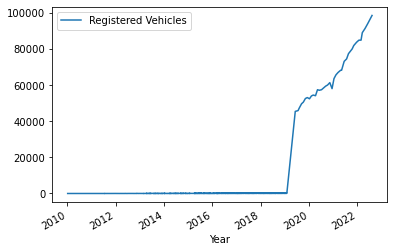

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df

## **RESAMPLING

In [5]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

<AxesSubplot:xlabel='Year'>

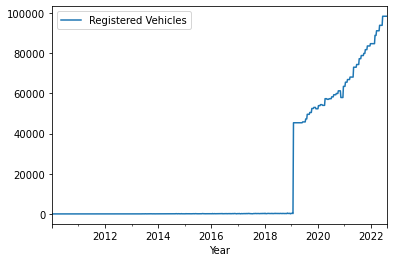

In [6]:
# Backfill 
df = df.resample('W').bfill()
df.plot()

In [7]:
# # #Frontfill 
# df = df.resample('M').ffill()
# df.plot()

## Testing 

In [8]:
adtest = adfuller(df)
display(adtest)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarning: invalid value encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


(nan,
 nan,
 0,
 657,
 {'1%': -3.440342440623255,
  '5%': -2.8659491890487026,
  '10%': -2.569118060113657},
 nan)

## Modeling

In [9]:
# Splitting Training and Testing data; using after 2019 as test

train = df['2018-06-30':'2020-12-31']
test = df['2020-12-31':]
combined = df

test

,Registered Vehicles
Year,
2021-01-03,63504.0
2021-01-10,63504.0
2021-01-17,65584.0
2021-01-24,65584.0
2021-01-31,65584.0
...,...
2022-07-17,98420.0
2022-07-24,98420.0
2022-07-31,98420.0


In [10]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3190.231, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3029.008, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2557.709, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2559.706, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2559.869, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2561.869, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2561.842, Time=0.05 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.691 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  131
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1275.85

### The best model is :  ARIMA (1,0,0) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0034      0.034     29.097      0.000       0.936       1.071
sigma2      1.626e+07    2.6e+05     62.566      0.000    1.57e+07    1.68e+07


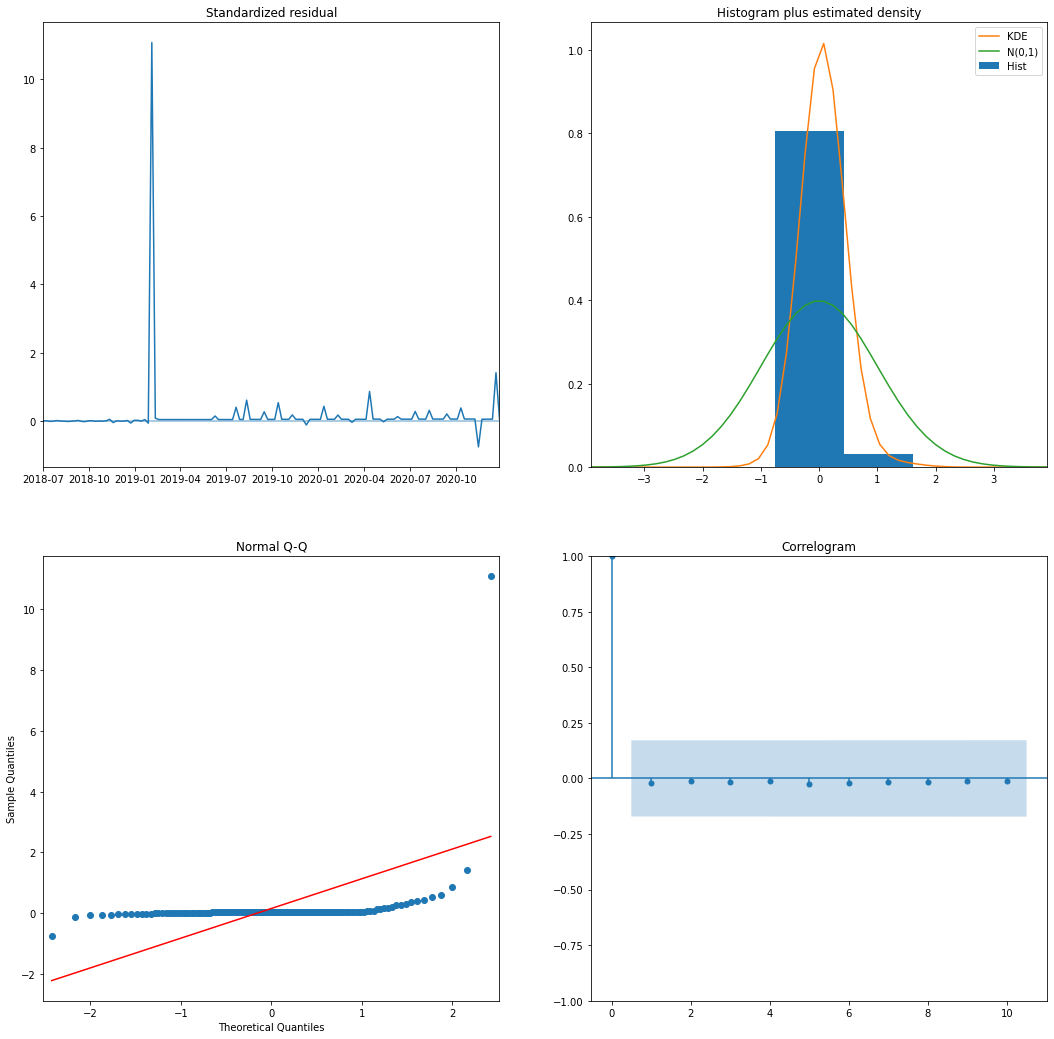

In [11]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(1,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [12]:
pred = output.get_prediction(start=pd.to_datetime('2021-01-31'), end=pd.to_datetime('2022-08-31'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2021-01-31,46802.638701,82387.155559
2021-02-07,45291.439440,84339.190795
2021-02-14,43912.074622,86160.895858
2021-02-21,42636.639858,87880.180271
2021-02-28,41445.783722,89516.400609
...,...,...
2022-08-07,544.283069,168539.848299
2022-08-14,176.460585,169484.638711
2022-08-21,-189.763342,170429.799361
2022-08-28,-554.429494,171375.377749


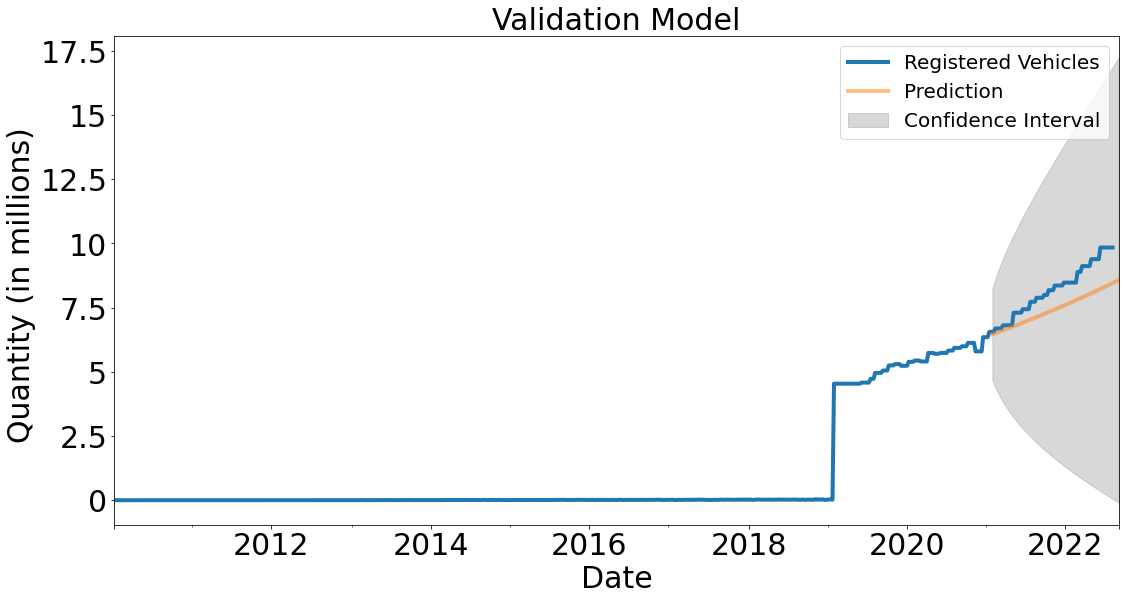

In [13]:


rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in millions) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e4
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()